In [2]:
import re
import pandas as pd
import numpy as np
import requests
import helpers_iex as h
from finviz.screener import Screener as fs
import yfinance as yf

import urllib3
# disabling warning when using 'requests.get(_, verify=False)'
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [3]:
from sklearn.preprocessing import minmax_scale
from scipy.stats import percentileofscore as perc_score
from mpl_toolkits.mplot3d import axes3d
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('ggplot')
%matplotlib inline


pd.options.display.max_columns = 100

In [3]:
filter = fs.load_filter_dict()

filters = [
    filter['Country']['USA'],
    filter['Industry']['Stocks only (ex-Funds)'],
    filter['Price']['Over $10'],
    filter['Current Volume']['Over 500K'],
    filter['Average Volume']['Over 500K'],
    filter['Relative Volume']['Over 0.5'],
    filter['Volatility']['Month - Over 2%'],
]

stock_list = fs(filters=filters, table='Performance')

print(stock_list)

100%|██████████| 62/62 [00:22<00:00,  2.71it/s]

No.  | Ticker | Perf Week | Perf Month | Perf Quart | Perf Half | Perf Year | Perf YTD | Volatility W | Volatility M | Recom | Avg Volume | Rel Volume | Price   | Change  | Volume     
---- | ------ | --------- | ---------- | ---------- | --------- | --------- | -------- | ------------ | ------------ | ----- | ---------- | ---------- | ------- | ------- | -----------
1    | A      | -3.10%    | -6.26%     | -11.63%    | 3.42%     | 27.28%    | 27.79%   | 2.97%        | 2.81%        | -     | 1.54M      | 1.64       | 151.42  | 0.41%   | 2,524,896  
2    | AA     | 10.10%    | 12.12%     | 10.87%     | 62.38%    | 142.25%   | 133.10%  | 5.52%        | 5.15%        | 1.80  | 8.37M      | 3.78       | 53.73   | 2.17%   | 31,656,918 
3    | AAL    | -5.89%    | -14.65%    | -16.63%    | -24.50%   | 0.89%     | 7.48%    | 5.01%        | 5.34%        | 3.10  | 34.56M     | 1.18       | 16.95   | 2.60%   | 40,911,779 
4    | AAP    | -3.01%    | 0.12%      | 14.29%     | 17.31%    | 45.20%   

In [4]:
df = pd.DataFrame(stock_list.data).iloc[:, 1:]
df.head()

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom,Avg Volume,Rel Volume,Price,Change,Volume
0,A,-3.10%,-6.26%,-11.63%,3.42%,27.28%,27.79%,2.97%,2.81%,-,1.54M,1.64,151.42,0.41%,"2,524,896"
1,AA,10.10%,12.12%,10.87%,62.38%,142.25%,133.10%,5.52%,5.15%,1.80,8.37M,3.78,53.73,2.17%,"31,656,918"
2,AAL,-5.89%,-14.65%,-16.63%,-24.50%,0.89%,7.48%,5.01%,5.34%,3.10,34.56M,1.18,16.95,2.60%,"40,911,779"
3,AAP,-3.01%,0.12%,14.29%,17.31%,45.20%,47.81%,2.32%,2.39%,2.20,630.47K,2.43,232.82,-2.65%,"1,531,694"
4,AAPL,-4.63%,11.50%,19.73%,29.36%,32.98%,28.98%,3.89%,2.97%,1.90,88.70M,2.19,171.14,-0.65%,"194,417,692"


In [5]:
df.shape

(1224, 15)

In [6]:
columns = df.columns.to_list()
columns = [x.replace(' ', '') for x in columns]
# Not addind but will need to calculate: ['Day of Week', 'Day of Month', 'Week of Year', 'Month of Year']
columns += ['YearHigh', 'YearLow', 'Date', 'MktCap', 'SplitDate']
ownership = ['SharesOUT', 'SharesShort', 'InstitOwn', 'InsiderOwn']
financial = ['ROI', 'ROA', 'ROE', 'EarningsDate']

In [200]:
stock = yf.Ticker('IBM')
stock

yfinance.Ticker object <IBM>

In [201]:
stock.history('3mo')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-20,126.325764,127.533359,125.269117,126.712570,4990152,0.0,0.0
2021-09-21,127.467314,127.976766,125.420063,125.448364,4261927,0.0,0.0
2021-09-22,126.155942,127.712608,125.920083,127.014465,3767901,0.0,0.0
2021-09-23,127.599397,129.646648,127.391839,128.995667,3151807,0.0,0.0
2021-09-24,129.278710,130.646686,129.014550,129.712677,3100762,0.0,0.0
...,...,...,...,...,...,...,...
2021-12-13,123.760002,124.360001,120.790001,122.580002,6847500,0.0,0.0
2021-12-14,122.349998,125.029999,122.300003,123.760002,5716100,0.0,0.0
2021-12-15,123.800003,124.820000,122.180000,123.110001,4990000,0.0,0.0


In [202]:
stock.get_analysis()

,Max Age,End Date,Growth,Earnings Estimate Avg,Earnings Estimate Low,Earnings Estimate High,Earnings Estimate Year Ago Eps,Earnings Estimate Number Of Analysts,Earnings Estimate Growth,Revenue Estimate Avg,Revenue Estimate Low,Revenue Estimate High,Revenue Estimate Number Of Analysts,Revenue Estimate Year Ago Revenue,Revenue Estimate Growth,Eps Trend Current,Eps Trend 7Days Ago,Eps Trend 30Days Ago,Eps Trend 60Days Ago,Eps Trend 90Days Ago,Eps Revisions Up Last7Days,Eps Revisions Up Last30Days,Eps Revisions Down Last30Days,Eps Revisions Down Last90Days
Period,,,,,,,,,,,,,,,,,,,,,,,,
0Q,1,2021-12-31,0.66200,3.44,3.25,3.94,2.07,5.0,0.662,1.643840e+10,1.565200e+10,1.732400e+10,5.0,2.036700e+10,-0.193,3.44,3.45,3.50,4.18,4.19,0.0,0.0,1.0,NaN
+1Q,1,2022-03-31,0.08500,1.92,1.74,2.03,1.77,3.0,0.085,1.336630e+10,1.298550e+10,1.404200e+10,3.0,1.734470e+10,-0.229,1.92,1.92,2.00,2.05,2.04,0.0,0.0,0.0,NaN
0Y,1,2021-12-31,0.12100,9.72,7.51,10.56,8.67,7.0,0.121,6.867520e+10,5.938600e+10,7.141700e+10,6.0,7.362000e+10,-0.067,9.72,9.73,9.70,10.72,10.73,0.0,0.0,1.0,NaN
+1Y,1,2022-12-31,0.06100,10.31,7.57,12.18,9.72,6.0,0.061,5.903770e+10,5.584080e+10,6.144800e+10,5.0,6.867520e+10,-0.140,10.31,10.16,10.13,11.80,11.79,1.0,1.0,0.0,NaN
+5Y,1,NaT,0.06900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5Y,1,NaT,-0.04993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
stock.get_earnings()

,Revenue,Earnings
Year,,
2017,79139000000,5753000000
2018,79591000000,8728000000
2019,77147000000,9431000000
2020,73621000000,5590000000


In [204]:
stock.get_info()

{'zip': '10504',
 'sector': 'Technology',
 'fullTimeEmployees': 345900,
 'longBusinessSummary': "International Business Machines Corporation provides integrated solutions and services worldwide. Its Cloud & Cognitive Software segment offers software for vertical and domain-specific solutions in various application areas; and customer information control system and storage, and analytics and integration software solutions to support client mission on-premise workloads in banking, airline, and retail industries. It offers middleware and data platform software, including Red Hat that enables the operation of clients' hybrid multi-cloud environments; and Cloud Paks, WebSphere distributed, and analytics platform software, such as DB2 distributed, information integration, and enterprise content management, as well as IoT, Blockchain and AI/Watson platforms. The company's Global Business Services segment offers business consulting services; system integration, application management, maintena

In [205]:
stock.get_institutional_holders()

,Holder,Shares,Date Reported,% Out,Value
0,"Vanguard Group, Inc. (The)",74936478,2021-09-29,0.0836,10410924888
1,Blackrock Inc.,64528194,2021-09-29,0.0720,8964901992
2,State Street Corporation,51361559,2021-09-29,0.0573,7135661391
3,"Geode Capital Management, LLC",14756888,2021-09-29,0.0165,2050174449
4,"Charles Schwab Investment Management, Inc.",14240958,2021-09-29,0.0159,1978496294
5,Morgan Stanley,11311218,2021-09-29,0.0126,1571467516
6,Northern Trust Corporation,10827475,2021-09-29,0.0121,1504261101
7,Norges Bank Investment Management,8865649,2020-12-30,0.0099,1116007896
8,Bank of America Corporation,8658711,2021-09-29,0.0097,1202954719
9,Bank Of New York Mellon Corporation,8545957,2021-09-29,0.0095,1187289806


In [206]:
stock.get_major_holders()

,0,1
0,0.13%,% of Shares Held by All Insider
1,57.77%,% of Shares Held by Institutions
2,57.85%,% of Float Held by Institutions
3,2740,Number of Institutions Holding Shares


In [207]:
stock.get_news()

[{'uuid': 'a4ead1ae-ca83-3a3e-99be-45ce92b3afb1',
  'title': 'LVIP ClearBridge Franklin Select Large Cap Managed Volatility Fund Buys HubSpot Inc, Cisco ...',
  'publisher': 'GuruFocus.com',
  'link': 'https://finance.yahoo.com/news/lvip-clearbridge-franklin-select-large-103802678.html',
  'providerPublishTime': 1639996682,
  'type': 'STORY'},
 {'uuid': 'c6c1a427-431a-3d7f-9604-742361df15ce',
  'title': 'Here Are Barron’s 10 Top Stocks for the New Year',
  'publisher': 'Barrons.com',
  'link': 'https://finance.yahoo.com/m/c6c1a427-431a-3d7f-9604-742361df15ce/here-are-barron%E2%80%99s-10-top.html',
  'providerPublishTime': 1639933080,
  'type': 'STORY'},
 {'uuid': 'e9039699-accb-33f0-be3e-fcbc2e199876',
  'title': 'Goldman Sachs Variable Insurance Trust Large Cap Value Fund Buys Salesforce. ...',
  'publisher': 'GuruFocus.com',
  'link': 'https://finance.yahoo.com/news/goldman-sachs-variable-insurance-trust-033803560.html',
  'providerPublishTime': 1639798683,
  'type': 'STORY'},
 {'uui

In [208]:
stock.get_calendar()

,Value
Earnings Date,2022-01-24 21:00:00
Earnings Average,3.44
Earnings Low,3.25
Earnings High,3.94
Revenue Average,16438400000
Revenue Low,15652000000
Revenue High,17324000000


In [209]:
stock.get_recommendations()

,Firm,To Grade,From Grade,Action
Date,,,,
2012-03-14 15:29:00,Oxen Group,Buy,,init
2012-03-23 11:44:00,UBS,Neutral,,main
2012-04-03 07:52:00,JP Morgan,Overweight,,main
2012-04-04 06:00:00,Bank oferica,Neutral,,down
2012-04-16 06:12:00,Credit Suisse,Neutral,,main
...,...,...,...,...
2021-07-20 10:58:27,Citigroup,Neutral,,main
2021-07-20 13:14:57,Morgan Stanley,Equal-Weight,,main
2021-10-01 10:07:36,Jefferies,Buy,,init


In [210]:
stock.option_chain()[0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,IBM211223C00095000,2021-12-01 20:15:29,95.0,23.15,0.0,0.0,0.0,0.0,35.0,35,0.000010,True,REGULAR,USD
1,IBM211223C00104000,2021-12-15 18:17:35,104.0,19.35,0.0,0.0,0.0,0.0,NaN,3,0.000010,True,REGULAR,USD
2,IBM211223C00108000,2021-12-15 20:47:08,108.0,14.80,0.0,0.0,0.0,0.0,9.0,10,0.000010,True,REGULAR,USD
3,IBM211223C00109000,2021-12-16 14:30:08,109.0,14.60,0.0,0.0,0.0,0.0,NaN,1,0.000010,True,REGULAR,USD
4,IBM211223C00110000,2021-12-08 20:51:54,110.0,13.28,0.0,0.0,0.0,0.0,25.0,25,0.000010,True,REGULAR,USD
5,IBM211223C00114000,2021-12-08 15:52:59,114.0,8.53,0.0,0.0,0.0,0.0,1.0,20,0.000010,True,REGULAR,USD
6,IBM211223C00115000,2021-12-16 16:09:55,115.0,11.10,0.0,0.0,0.0,0.0,13.0,0,0.000010,True,REGULAR,USD
7,IBM211223C00116000,2021-12-15 19:31:05,116.0,6.80,0.0,0.0,0.0,0.0,1.0,127,0.000010,True,REGULAR,USD
8,IBM211223C00117000,2021-12-17 17:55:31,117.0,11.03,0.0,0.0,0.0,0.0,28.0,153,0.000010,True,REGULAR,USD
9,IBM211223C00118000,2021-12-17 19:57:15,118.0,10.00,0.0,0.0,0.0,0.0,28.0,0,0.000010,True,REGULAR,USD


In [211]:
stock.option_chain()[1]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,IBM211223P00090000,2021-11-19 15:51:50,90.0,0.14,0.00,0.75,0.0,0.0,2,2,1.929688,False,REGULAR,USD
1,IBM211223P00095000,2021-11-26 15:18:11,95.0,0.06,0.00,0.00,0.0,0.0,4,4,0.500005,False,REGULAR,USD
2,IBM211223P00100000,2021-12-06 20:09:12,100.0,0.19,0.00,0.00,0.0,0.0,1,46,0.500005,False,REGULAR,USD
3,IBM211223P00105000,2021-12-08 15:13:51,105.0,0.18,0.00,0.00,0.0,0.0,1,0,0.500005,False,REGULAR,USD
4,IBM211223P00106000,2021-12-01 16:08:55,106.0,0.27,0.00,0.00,0.0,0.0,1,36,0.500005,False,REGULAR,USD
5,IBM211223P00107000,2021-11-19 18:08:57,107.0,0.49,0.00,0.58,0.0,0.0,15,15,1.037114,False,REGULAR,USD
6,IBM211223P00108000,2021-12-06 19:50:31,108.0,0.26,0.00,0.00,0.0,0.0,1,49,0.250007,False,REGULAR,USD
7,IBM211223P00109000,2021-12-03 19:24:14,109.0,0.71,0.00,0.00,0.0,0.0,2,21,0.250007,False,REGULAR,USD
8,IBM211223P00110000,2021-12-16 20:11:08,110.0,0.02,0.00,0.00,0.0,0.0,2,229,0.250007,False,REGULAR,USD
9,IBM211223P00111000,2021-12-09 18:47:24,111.0,0.13,0.00,0.00,0.0,0.0,2,17,0.250007,False,REGULAR,USD


In [212]:
test = stock.option_chain()[0].copy()
test['actualPrice'] = test['strike'] + test['bid'].fillna(0).add(0.01)
test['relevance'] = test['bid'].fillna(0).add(0.01) * test['volume'].fillna(0).add(1) * test['openInterest'].fillna(0).add(1)
test['relevanceCumulative'] = test['relevance'].cumsum()
test['relevancePercent'] = [perc_score(test['relevance'], x) for x in test['relevance']]
test

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,actualPrice,relevance,relevanceCumulative,relevancePercent
0,IBM211223C00095000,2021-12-01 20:15:29,95.0,23.15,0.0,0.0,0.0,0.0,35.0,35,0.000010,True,REGULAR,USD,95.01,12.96,12.96,60.000000
1,IBM211223C00104000,2021-12-15 18:17:35,104.0,19.35,0.0,0.0,0.0,0.0,NaN,3,0.000010,True,REGULAR,USD,104.01,0.04,13.00,10.000000
2,IBM211223C00108000,2021-12-15 20:47:08,108.0,14.80,0.0,0.0,0.0,0.0,9.0,10,0.000010,True,REGULAR,USD,108.01,1.10,14.10,36.666667
3,IBM211223C00109000,2021-12-16 14:30:08,109.0,14.60,0.0,0.0,0.0,0.0,NaN,1,0.000010,True,REGULAR,USD,109.01,0.02,14.12,3.333333
4,IBM211223C00110000,2021-12-08 20:51:54,110.0,13.28,0.0,0.0,0.0,0.0,25.0,25,0.000010,True,REGULAR,USD,110.01,6.76,20.88,53.333333
5,IBM211223C00114000,2021-12-08 15:52:59,114.0,8.53,0.0,0.0,0.0,0.0,1.0,20,0.000010,True,REGULAR,USD,114.01,0.42,21.30,30.000000
6,IBM211223C00115000,2021-12-16 16:09:55,115.0,11.10,0.0,0.0,0.0,0.0,13.0,0,0.000010,True,REGULAR,USD,115.01,0.14,21.44,16.666667
7,IBM211223C00116000,2021-12-15 19:31:05,116.0,6.80,0.0,0.0,0.0,0.0,1.0,127,0.000010,True,REGULAR,USD,116.01,2.56,24.00,40.000000
8,IBM211223C00117000,2021-12-17 17:55:31,117.0,11.03,0.0,0.0,0.0,0.0,28.0,153,0.000010,True,REGULAR,USD,117.01,44.66,68.66,66.666667
9,IBM211223C00118000,2021-12-17 19:57:15,118.0,10.00,0.0,0.0,0.0,0.0,28.0,0,0.000010,True,REGULAR,USD,118.01,0.29,68.95,23.333333


In [213]:
selected_relevance = test[(test['relevancePercent'] >= 75) & (test['inTheMoney'] == False)]
selected_relevance

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,actualPrice,relevance,relevanceCumulative,relevancePercent
19,IBM211223C00128000,2021-12-17 20:59:53,128.0,1.26,0.0,0.0,0.0,0.0,542.0,328,0.015635,False,REGULAR,USD,128.01,1786.47,7344.18,90.000000
21,IBM211223C00130000,2021-12-17 20:59:58,130.0,0.52,0.0,0.0,0.0,0.0,2072.0,603,0.062509,False,REGULAR,USD,130.01,12520.92,19875.40,100.000000
22,IBM211223C00131000,2021-12-17 20:55:56,131.0,0.36,0.0,0.0,0.0,0.0,593.0,457,0.062509,False,REGULAR,USD,131.01,2720.52,22595.92,93.333333
26,IBM211223C00135000,2021-12-17 20:52:07,135.0,0.07,0.0,0.0,0.0,0.0,56.0,464,0.125009,False,REGULAR,USD,135.01,265.05,22867.70,76.666667
27,IBM211223C00140000,2021-12-17 20:40:13,140.0,0.03,0.0,0.0,0.0,0.0,144.0,221,0.250007,False,REGULAR,USD,140.01,321.90,23189.60,80.000000


In [214]:
weights = minmax_scale(selected_relevance['relevance']), [perc_score(selected_relevance['relevance'], x) / 100 for x in selected_relevance['relevance']]
weights

(array([0.12413807, 1.        , 0.20035053, 0.        , 0.00463859]),
 [0.6, 1.0, 0.8, 0.2, 0.4])

In [215]:
def add_relevance(df):
    df['volume'] = df['volume'].fillna(0)
    df['bid'] = df['bid'].fillna(0)
    date_range = (df['lastTradeDate'].max() - df['lastTradeDate'].min()).days + 1
    df['dateRelevance'] = (date_range - (df['lastTradeDate'].max() - df['lastTradeDate']).dt.days) / date_range
    df['actualPrice'] = df['strike'] + df['bid'].add(0.01)
    df['relevance'] = df['actualPrice'] * df['volume'].add(1) * np.sqrt(df['openInterest'].add(1)) * df['dateRelevance']
    df['relevanceCumulative'] = df['relevance'].cumsum() / df['relevance'].sum()
    df['relevancePercent'] = [perc_score(df['relevance'], x) for x in df['relevance']]
    return df.drop(columns=['contractSymbol', 'contractSize', 'currency'])

In [216]:
calls_relevance_df = add_relevance(stock.option_chain()[0])
calls_relevance_df

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,dateRelevance,actualPrice,relevance,relevanceCumulative,relevancePercent
0,2021-12-01 20:15:29,95.0,23.15,0.0,0.0,0.0,0.0,35.0,35,0.000010,True,0.058824,95.01,1.207186e+03,0.000091,20.000000
1,2021-12-15 18:17:35,104.0,19.35,0.0,0.0,0.0,0.0,0.0,3,0.000010,True,0.882353,104.01,1.835471e+02,0.000105,6.666667
2,2021-12-15 20:47:08,108.0,14.80,0.0,0.0,0.0,0.0,9.0,10,0.000010,True,0.882353,108.01,3.160841e+03,0.000344,33.333333
3,2021-12-16 14:30:08,109.0,14.60,0.0,0.0,0.0,0.0,0.0,1,0.000010,True,0.941176,109.01,1.450950e+02,0.000355,3.333333
4,2021-12-08 20:51:54,110.0,13.28,0.0,0.0,0.0,0.0,25.0,25,0.000010,True,0.470588,110.01,6.863304e+03,0.000873,46.666667
5,2021-12-08 15:52:59,114.0,8.53,0.0,0.0,0.0,0.0,1.0,20,0.000010,True,0.470588,114.01,4.917265e+02,0.000910,16.666667
6,2021-12-16 16:09:55,115.0,11.10,0.0,0.0,0.0,0.0,13.0,0,0.000010,True,0.941176,115.01,1.515426e+03,0.001025,23.333333
7,2021-12-15 19:31:05,116.0,6.80,0.0,0.0,0.0,0.0,1.0,127,0.000010,True,0.882353,116.01,2.316182e+03,0.001200,30.000000
8,2021-12-17 17:55:31,117.0,11.03,0.0,0.0,0.0,0.0,28.0,153,0.000010,True,1.000000,117.01,4.210962e+04,0.004380,60.000000
9,2021-12-17 19:57:15,118.0,10.00,0.0,0.0,0.0,0.0,28.0,0,0.000010,True,1.000000,118.01,3.422290e+03,0.004639,36.666667


In [217]:
puts_relevance_df = add_relevance(stock.option_chain()[1])
puts_relevance_df

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,dateRelevance,actualPrice,relevance,relevanceCumulative,relevancePercent
0,2021-11-19 15:51:50,90.0,0.14,0.00,0.75,0.0,0.0,2,2,1.929688,False,0.222222,90.01,1.039346e+02,0.000035,2.702703
1,2021-11-26 15:18:11,95.0,0.06,0.00,0.00,0.0,0.0,4,4,0.500005,False,0.416667,95.01,4.426017e+02,0.000187,16.216216
2,2021-12-06 20:09:12,100.0,0.19,0.00,0.00,0.0,0.0,1,46,0.500005,False,0.694444,100.01,9.522695e+02,0.000512,29.729730
3,2021-12-08 15:13:51,105.0,0.18,0.00,0.00,0.0,0.0,1,0,0.500005,False,0.750000,105.01,1.575150e+02,0.000566,8.108108
4,2021-12-01 16:08:55,106.0,0.27,0.00,0.00,0.0,0.0,1,36,0.500005,False,0.555556,106.01,7.164818e+02,0.000810,21.621622
5,2021-11-19 18:08:57,107.0,0.49,0.00,0.58,0.0,0.0,15,15,1.037114,False,0.222222,107.01,1.521920e+03,0.001330,45.945946
6,2021-12-06 19:50:31,108.0,0.26,0.00,0.00,0.0,0.0,1,49,0.250007,False,0.694444,108.01,1.060758e+03,0.001692,32.432432
7,2021-12-03 19:24:14,109.0,0.71,0.00,0.00,0.0,0.0,2,21,0.250007,False,0.611111,109.01,9.373874e+02,0.002012,27.027027
8,2021-12-16 20:11:08,110.0,0.02,0.00,0.00,0.0,0.0,2,229,0.250007,False,0.972222,110.01,4.866121e+03,0.003673,64.864865
9,2021-12-09 18:47:24,111.0,0.13,0.00,0.00,0.0,0.0,2,17,0.250007,False,0.777778,111.01,1.098943e+03,0.004049,35.135135


In [218]:
calls_relevance_df[calls_relevance_df['relevancePercent'] >= 90]['actualPrice'].min(), calls_relevance_df[calls_relevance_df['relevancePercent'] >= 90]['actualPrice'].max()

(127.01, 131.01)

In [219]:
puts_relevance_df[puts_relevance_df['relevancePercent'] >= 90]['actualPrice'].min(), puts_relevance_df[puts_relevance_df['relevancePercent'] >= 90]['actualPrice'].max()

(120.01, 127.01)

In [220]:
calls_relevance_df.loc[calls_relevance_df['relevancePercent'] >= 90]

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,dateRelevance,actualPrice,relevance,relevanceCumulative,relevancePercent
18,2021-12-17 20:53:34,127.0,1.56,0.0,0.0,0.0,0.0,547.0,610,0.000010,True,1.0,127.01,1.720438e+06,0.229418,96.666667
19,2021-12-17 20:59:53,128.0,1.26,0.0,0.0,0.0,0.0,542.0,328,0.015635,False,1.0,128.01,1.260787e+06,0.324647,90.000000
21,2021-12-17 20:59:58,130.0,0.52,0.0,0.0,0.0,0.0,2072.0,603,0.062509,False,1.0,130.01,6.623607e+06,0.834978,100.000000
22,2021-12-17 20:55:56,131.0,0.36,0.0,0.0,0.0,0.0,593.0,457,0.062509,False,1.0,131.01,1.665419e+06,0.960770,93.333333


In [221]:
puts_relevance_df[puts_relevance_df['relevancePercent'] >= 90]

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,dateRelevance,actualPrice,relevance,relevanceCumulative,relevancePercent
18,2021-12-17 20:49:57,120.0,0.11,0.0,0.0,0.0,0.0,156,381,0.125009,False,1.0,120.01,3.682551e+05,0.145732,97.297297
22,2021-12-17 20:39:32,124.0,0.40,0.0,0.0,0.0,0.0,127,162,0.062509,False,1.0,124.01,2.026565e+05,0.294097,91.891892
24,2021-12-17 20:59:47,126.0,0.91,0.0,0.0,0.0,0.0,147,152,0.031260,False,1.0,126.01,2.306813e+05,0.385191,94.594595
25,2021-12-17 20:59:45,127.0,1.17,0.0,0.0,0.0,0.0,674,372,0.007822,False,1.0,127.01,1.655755e+06,0.950498,100.000000


In [222]:
def option_relevance_range_filter(df, threshold):
    min_idx = df[df['relevancePercent'] >= threshold].index[0]
    max_idx = df[df['relevancePercent'] >= threshold].index[-1]
    return df.loc[min_idx:max_idx]

In [285]:
calls_relevance_range_df = option_relevance_range_filter(calls_relevance_df, 90)
calls_relevance_range_df

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,dateRelevance,actualPrice,relevance,relevanceCumulative,relevancePercent
18,2021-12-17 20:53:34,127.0,1.56,0.0,0.0,0.0,0.0,547.0,610,0.000010,True,1.0,127.01,1.720438e+06,0.229418,96.666667
19,2021-12-17 20:59:53,128.0,1.26,0.0,0.0,0.0,0.0,542.0,328,0.015635,False,1.0,128.01,1.260787e+06,0.324647,90.000000
20,2021-12-17 20:58:48,129.0,0.81,0.0,0.0,0.0,0.0,1029.0,0,0.031260,False,1.0,129.01,1.328803e+05,0.334684,70.000000
21,2021-12-17 20:59:58,130.0,0.52,0.0,0.0,0.0,0.0,2072.0,603,0.062509,False,1.0,130.01,6.623607e+06,0.834978,100.000000
22,2021-12-17 20:55:56,131.0,0.36,0.0,0.0,0.0,0.0,593.0,457,0.062509,False,1.0,131.01,1.665419e+06,0.960770,93.333333


In [284]:
puts_relevance_range_df = option_relevance_range_filter(puts_relevance_df, 90)
puts_relevance_range_df

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,dateRelevance,actualPrice,relevance,relevanceCumulative,relevancePercent
18,2021-12-17 20:49:57,120.0,0.11,0.0,0.0,0.0,0.0,156,381,0.125009,False,1.0,120.01,3.682551e+05,0.145732,97.297297
19,2021-12-17 18:41:17,121.0,0.16,0.0,0.0,0.0,0.0,80,273,0.125009,False,1.0,121.01,1.622488e+05,0.201127,89.189189
20,2021-12-17 20:59:25,122.0,0.18,0.0,0.0,0.0,0.0,78,0,0.125009,False,1.0,122.01,9.638790e+03,0.204418,70.270270
21,2021-12-17 20:47:25,123.0,0.28,0.0,0.0,0.0,0.0,28,282,0.062509,False,1.0,123.01,6.001111e+04,0.224907,83.783784
22,2021-12-17 20:39:32,124.0,0.40,0.0,0.0,0.0,0.0,127,162,0.062509,False,1.0,124.01,2.026565e+05,0.294097,91.891892
23,2021-12-17 20:59:27,125.0,0.57,0.0,0.0,0.0,0.0,288,0,0.062509,False,1.0,125.01,3.612789e+04,0.306432,81.081081
24,2021-12-17 20:59:47,126.0,0.91,0.0,0.0,0.0,0.0,147,152,0.031260,False,1.0,126.01,2.306813e+05,0.385191,94.594595
25,2021-12-17 20:59:45,127.0,1.17,0.0,0.0,0.0,0.0,674,372,0.007822,False,1.0,127.01,1.655755e+06,0.950498,100.000000


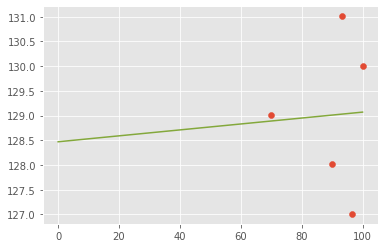

In [225]:
line = np.linspace(0, 100, num=101, endpoint=True)
m, b = np.polyfit(calls_relevance_range_df['relevancePercent'], calls_relevance_range_df['actualPrice'], 1)
plt.scatter(calls_relevance_range_df['relevancePercent'], calls_relevance_range_df['actualPrice'])
plt.plot(line * m + b, c='g')
plt.show()

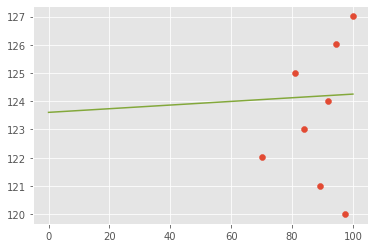

In [226]:
line = np.linspace(90, 100, num=101, endpoint=True)
m, b = np.polyfit(puts_relevance_range_df['relevancePercent'], puts_relevance_range_df['actualPrice'], 1)
plt.scatter(puts_relevance_range_df['relevancePercent'], puts_relevance_range_df['actualPrice'])
plt.plot(line * m + b, c='g')
plt.show()

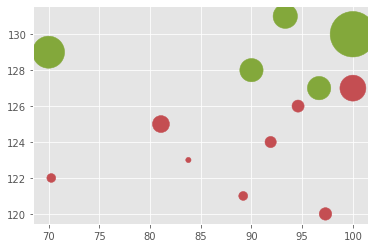

In [227]:
plt.scatter(calls_relevance_range_df['relevancePercent'], calls_relevance_range_df['strike'], c='g', s=calls_relevance_range_df['volume'])
plt.scatter(puts_relevance_range_df['relevancePercent'], puts_relevance_range_df['strike'], c='r', s=puts_relevance_range_df['volume'])
plt.show()

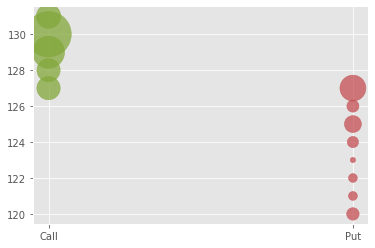

In [358]:
plt.scatter(np.zeros(calls_relevance_range_df['relevancePercent'].shape[0]), calls_relevance_range_df['actualPrice'], c='g', s=calls_relevance_range_df['volume'], alpha=0.75)
plt.scatter(np.ones(puts_relevance_range_df['relevancePercent'].shape[0]), puts_relevance_range_df['actualPrice'], c='r', s=puts_relevance_range_df['volume'], alpha=0.75)
plt.xticks([0, 1], labels=['Call', 'Put'])
plt.show()

In [265]:
calls_relevance_range_df['lastTradeDate'].dt.date

18    2021-12-17
19    2021-12-17
20    2021-12-17
21    2021-12-17
22    2021-12-17
Name: lastTradeDate, dtype: object

In [356]:
def plot_options(call_strike, call_volume, put_strike, put_volume, current_price):
    fig, axes = plt.subplots(figsize=(24, 3))
    plt.scatter(call_strike, np.zeros(len(call_strike)), c='g', s=call_volume, alpha=0.75)
    plt.scatter(put_strike, np.ones(len(put_strike)), c='r', s=put_volume, alpha=0.75)
    plt.axvline(current_price, c='b')
    plt.ylim([-0.5, 1.5])
    plt.yticks([])
    plt.xticks(np.arange(min(min(call_strike), min(put_strike)) - 1, max(max(call_strike), max(put_strike)) + 1, 1), rotation=45)
    plt.xlabel('Strike')
    plt.title('Options by volume')
    plt.legend(['Call', 'Put'])
    plt.show()

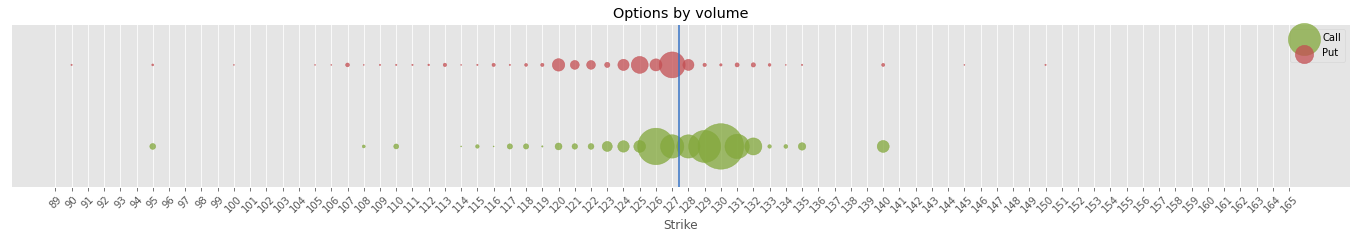

In [357]:
plot_options(calls_relevance_df['strike'], calls_relevance_df['volume'], puts_relevance_df['strike'], puts_relevance_df['volume'], stock.get_info()['currentPrice'])

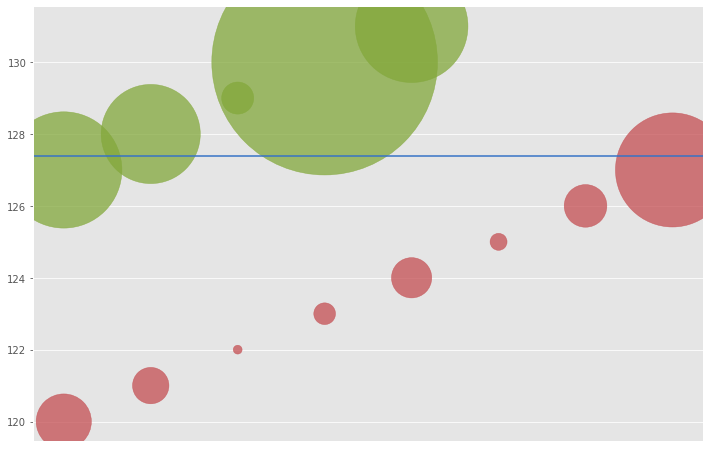

In [300]:
fig, axes = plt.subplots(figsize=(12, 8))
plt.scatter(np.arange(calls_relevance_range_df.shape[0]), calls_relevance_range_df['strike'], c='g', s=calls_relevance_range_df['volume'] * np.sqrt(calls_relevance_range_df['openInterest'].add(1)), alpha=0.75)
plt.scatter(np.arange(puts_relevance_range_df.shape[0]), puts_relevance_range_df['strike'], c='r', s=puts_relevance_range_df['volume'] * np.sqrt(puts_relevance_range_df['openInterest'].add(1)), alpha=0.75)
plt.axhline(stock.get_info()['currentPrice'], c='b')
plt.xticks([])
plt.show()

In [228]:
calls_relevance_df[calls_relevance_df['relevancePercent'] >= 90]['volume'].sum(), calls_relevance_df[calls_relevance_df['relevancePercent'] >= 90]['actualPrice'].max()

(3754.0, 131.01)

In [229]:
puts_relevance_df[puts_relevance_df['relevancePercent'] >= 90]['volume'].sum(), puts_relevance_df[puts_relevance_df['relevancePercent'] >= 90]['actualPrice'].min()

(1104, 120.01)

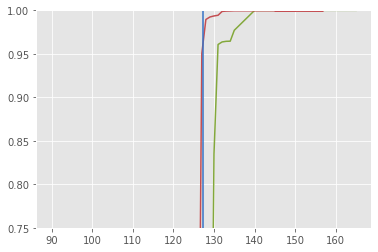

In [230]:
plt.plot(calls_relevance_df['actualPrice'], calls_relevance_df['relevanceCumulative'], c='g')
plt.plot(puts_relevance_df['actualPrice'], puts_relevance_df['relevanceCumulative'], c='r')
plt.axvline(stock.get_info()['currentPrice'], c='b')
plt.ylim([0.75, 1.0])
plt.show()

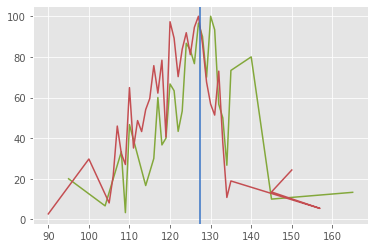

In [231]:
plt.plot(calls_relevance_df['actualPrice'], calls_relevance_df['relevancePercent'], c='g')
plt.plot(puts_relevance_df['actualPrice'], puts_relevance_df['relevancePercent'], c='r')
plt.axvline(stock.get_info()['currentPrice'], c='b')
plt.show()

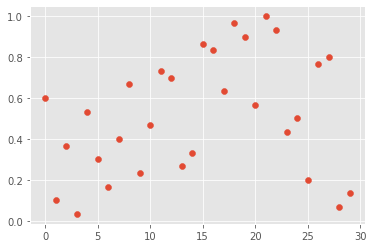

In [232]:
plt.scatter(np.arange(len(test['relevance'])), [perc_score(test['relevance'], x) / 100 for x in test['relevance']])

In [233]:
np.where(np.array([perc_score(test['relevance'], x) / 100 for x in test['relevance']]) > 0.85)

(array([15, 18, 19, 21, 22], dtype=int64),)

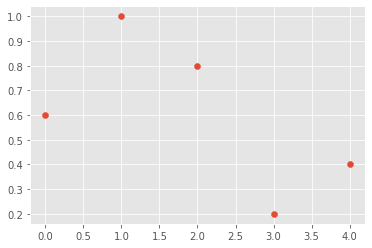

In [234]:
plt.scatter(np.arange(len(weights[1])), weights[1])

In [235]:
np.argwhere(np.array(weights[1]) >= 0.75).flatten()

array([1, 2], dtype=int64)

In [236]:
selected_relevance.iloc[np.argwhere(np.array(weights[1]) >= 0.75).flatten()]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,actualPrice,relevance,relevanceCumulative,relevancePercent
21,IBM211223C00130000,2021-12-17 20:59:58,130.0,0.52,0.0,0.0,0.0,0.0,2072.0,603,0.062509,False,REGULAR,USD,130.01,12520.92,19875.40,100.000000
22,IBM211223C00131000,2021-12-17 20:55:56,131.0,0.36,0.0,0.0,0.0,0.0,593.0,457,0.062509,False,REGULAR,USD,131.01,2720.52,22595.92,93.333333


In [237]:
(selected_relevance['strike'] + selected_relevance['bid']) * weights[1]

19     76.8
21    130.0
22    104.8
26     27.0
27     56.0
dtype: float64

In [238]:
stock.option_chain()[1]['openInterest'].quantile(.75) - stock.option_chain()[1]['openInterest'].quantile(.25)

150.0

In [239]:
stock.option_chain()[1]['openInterest'].median(), stock.option_chain()[1]['volume'].median()

(23.0, 8.0)

In [240]:
stock.option_chain()[1]['openInterest'].mean(), stock.option_chain()[1]['volume'].mean()

(80.45945945945945, 50.32432432432432)

In [241]:
stock.option_chain()[1]['openInterest'].quantile(.25), stock.option_chain()[1]['openInterest'].quantile(.75), stock.option_chain()[1]['volume'].quantile(.25), stock.option_chain()[1]['volume'].quantile(.75)

(2.0, 152.0, 2.0, 19.0)

In [242]:
stock.option_chain()[1]['openInterest'].max(), stock.option_chain()[1]['volume'].max()

(381, 674)

In [243]:
# Strict price prediction based on open interest in calls
stock.option_chain()[0]['strike'][np.argmax(stock.option_chain()[0]['openInterest'])] + stock.option_chain()[0]['ask'][np.argmax(stock.option_chain()[0]['openInterest'])]

124.0

In [244]:
# Strict price prediction based on open interest in puts
stock.option_chain()[1]['strike'][np.argmax(stock.option_chain()[1]['openInterest'])] + stock.option_chain()[1]['ask'][np.argmax(stock.option_chain()[1]['openInterest'])]

120.0

In [245]:
stock.options

('2021-12-23',
 '2021-12-31',
 '2022-01-07',
 '2022-01-14',
 '2022-01-21',
 '2022-01-28',
 '2022-02-18',
 '2022-03-18',
 '2022-04-14',
 '2022-06-17',
 '2022-07-15',
 '2023-01-20',
 '2024-01-19')

In [246]:
assert 1 == 0

AssertionError: 

In [ ]:
def predict_price_on_options(ticker):
    stock = yf.Ticker(ticker)
    puts = stock.option_chain()[1]
    calls = stock.option_chain()[0]
    expiration_date = stock.options[0]
    raw_prediction_puts = puts['strike'][np.argmax(puts['openInterest'])] + puts['ask'][np.argmax(puts['openInterest'])]
    raw_prediction_calls = calls['strike'][np.argmax(calls['openInterest'])] + calls['ask'][np.argmax(calls['openInterest'])]
    return raw_prediction_puts, raw_prediction_calls, expiration_date


print(f'Prediction on options: {predict_price_on_options("GTLB")}')

Prediction on options: (91.2, 97.9, '2022-01-21')


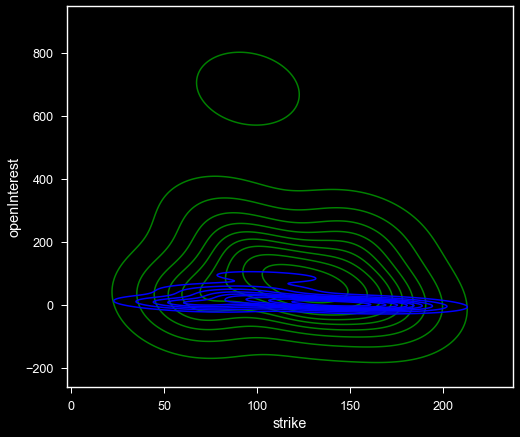

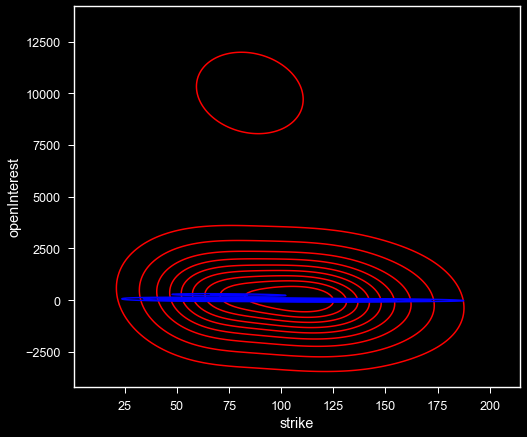

In [ ]:
plt.style.use('dark_background')

data = stock.option_chain()

sns.kdeplot(data=data[0], x='strike', y='openInterest', color='green')
sns.kdeplot(data=data[0], x='strike', y='volume', color='blue')
plt.grid(False)
plt.show()
sns.kdeplot(data=data[1], x='strike', y='openInterest', color='red')
sns.kdeplot(data=data[1], x='strike', y='volume', color='blue')
plt.grid(False)
plt.show()

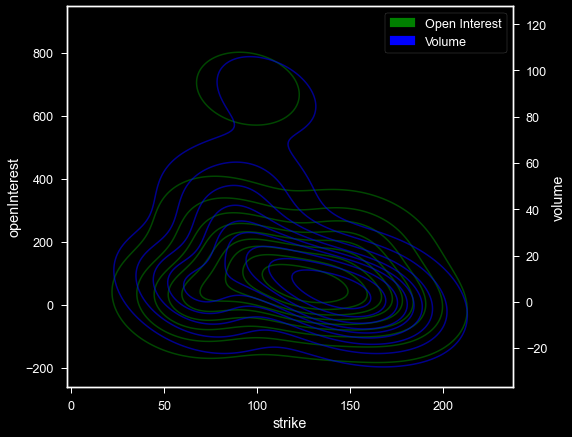

In [ ]:
color_palette = sns.color_palette(['green', 'blue'])

fig, ax1 = plt.subplots()
ax1 = sns.kdeplot(data=data[0], x='strike', y='openInterest', color=color_palette[0], alpha=0.55)
ax2 = ax1.twinx()
ax2 = sns.kdeplot(data=data[0], x='strike', y='volume', color=color_palette[1], alpha=0.55)
ax1.grid(False)
ax2.grid(False)
patches = [matplotlib.patches.Patch(color=color_palette[i], label=t) for i,t in enumerate(['Open Interest', 'Volume'])]
plt.legend(handles=patches)
plt.show()


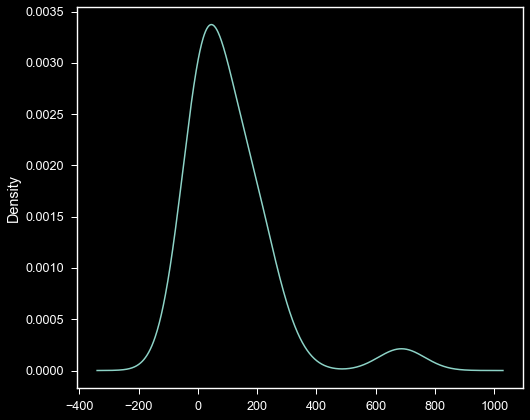

In [ ]:
pd.Series(data[0]['openInterest']).plot(kind='density')
plt.grid(False)
plt.show()

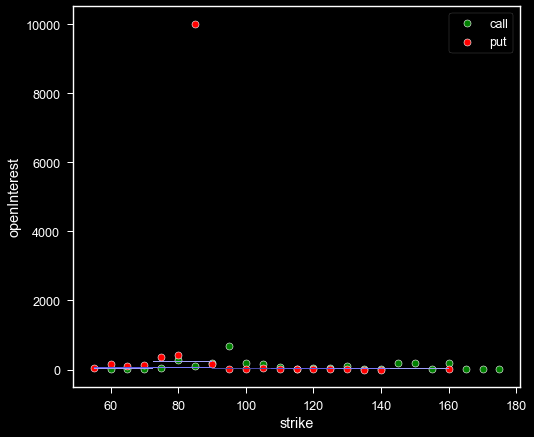

In [ ]:
sns.scatterplot(data=stock.option_chain()[0], x='strike', y='openInterest', color='green')
sns.scatterplot(data=stock.option_chain()[1], x='strike', y='openInterest', color='red')
sns.histplot(data=stock.option_chain()[1], x='strike', y='volume', color='blue')
plt.legend(['call', 'put'])
plt.show()

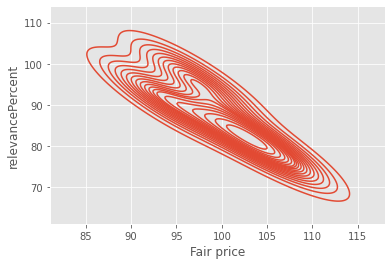

In [ ]:
sns.kdeplot(data=selected_relevance, x='actualPrice', y='relevancePercent', n_levels=20)
plt.xlabel('Fair price')
plt.show()

TypeError: tuple indices must be integers or slices, not str

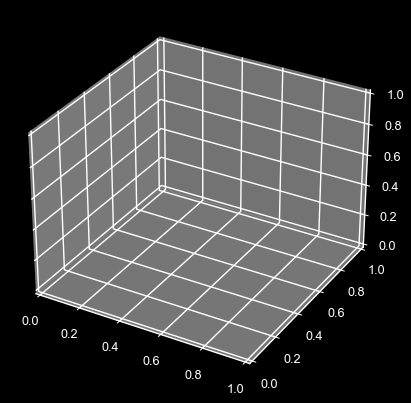

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)
X, Y, Z = data['strike'], data['openInterest'], data['volume']

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z)

plt.show()

In [ ]:
options = stock._download_options()
options

In [ ]:
import datetime

datetime.datetime.fromtimestamp(options['expiratibonDate'])

In [ ]:
stock.options

In [ ]:
api_url = h.get_api_url(['ADGI', ''], ['chart', 'stats', 'splits'])
api_url

{"avgTotalVolume":15468758,
"calculationPrice":"close",
"change":7.83,
"changePercent":1.23307,
"close":null,
"closeSource":"official",
"closeTime":null,
"companyName":"Adagio Therapeutics Inc",
"currency":"USD",
"delayedPrice":null,
"delayedPriceTime":null,
"extendedChange":null,
"extendedChangePercent":null,
"extendedPrice":null,
"extendedPriceTime":null,
"high":null,
"highSource":null,
"highTime":null,
"iexAskPrice":0,
"iexAskSize":0,
"iexBidPrice":0,
"iexBidSize":0,
"iexClose":14.21,
"iexCloseTime":1639688399590,
"iexLastUpdated":1639691997175,
"iexMarketPercent":2.152426692560861,
"iexOpen":6.43,
"iexOpenTime":1639665055611,
"iexRealtimePrice":13.51,
"iexRealtimeSize":100,
"iexVolume":2544700,
"lastTradeTime":1639688459092,
"latestPrice":14.18,
"latestSource":"Close",
"latestTime":"December 16,
 2021",
"latestUpdate":1639688400366,
"latestVolume":null,
"low":null,
"lowSource":null,
"lowTime":null,
"marketCap":1577548539,
"oddLotDelayedPrice":null,
"oddLotDelayedPriceTime":null,
"open":null,
"openTime":null,
"openSource":"official",
"peRatio":null,
"previousClose":6.35,
"previousVolume":16886849,
"primaryExchange":"NASDAQ",
"symbol":"ADGI",
"volume":null,
"week52High":78.82,
"week52Low":5.57,
"ytdChange":0.9121887739463603,
"isUSMarketOpen":false}

{"companyName":"Adagio Therapeutics Inc",
"marketcap":1577548539,
"week52high":78.82,
"week52low":5.57,
"week52highSplitAdjustOnly":78.82,
"week52lowSplitAdjustOnly":5.57,
"week52change":-0.3208812260536398,
"sharesOutstanding":111251660,
"float":0,
"avg10Volume":36521824,
"avg30Volume":15468758,
"day200MovingAvg":32.5,
"day50MovingAvg":27.15,
"employees":2021,
"ttmEPS":0,
"ttmDividendRate":0,
"dividendYield":0,
"nextDividendDate":"",
"exDividendDate":"",
"nextEarningsDate":"",
"peRatio":0,
"beta":0,
"maxChangePercent":-0.3208812260536398,
"year5ChangePercent":-0.3208812260536398,
"year2ChangePercent":-0.3208812260536398,
"year1ChangePercent":-0.3208812260536398,
"ytdChangePercent":-0.3208812260536398,
"month6ChangePercent":-0.3208812260536398,
"month3ChangePercent":-0.7471469329529243,
"month1ChangePercent":-0.29801980198019806,
"day30ChangePercent":-0.29801980198019806,
"day5ChangePercent":-0.5945095796396911}

In [ ]:
df.loc[df['Ticker'] == 'ADGI', :]

Checking data comparison for Dec 17, 2021:

- Finviz data for ADGI Market Cap: 1.66B
- Yahoo data for ADGI Market Cap: 1.578B
- Google data for ADGI Market Cap: 1.58B
- IEX data for ADGI Market Cap: 1577548539

In [ ]:
df.loc[df['Ticker'] == 'NEM', :]

From IEX will use Market Cap and 

In [ ]:
def convert_volume(col):
    new_col = col.str.replace('K', 'e+3')
    new_col = new_col.str.replace('M', 'e+6')
    new_col = new_col.str.replace(',', '')
    new_col = new_col.replace('-', np.nan)
    new_col = new_col.astype('float')
    new_col = new_col.astype('Int32')
    return new_col

def convert_percentage(col):
    new_col = col.str.replace('%', 'e-2')
    new_col = new_col.replace('-', np.nan)
    new_col = new_col.astype('float16')
    return new_col

perf_year = convert_percentage(df['Perf Year'])
print(perf_year[:5])

avg_vol = convert_volume(df['Avg Volume'])
print(avg_vol[:5])

In [ ]:
symbols = df['Ticker'].to_list()
symbols[:5]

In [ ]:
api_url = h.get_api_url([df.loc[0, 'Ticker']], types=['advanced-stats'])
data = requests.get(api_url, verify=False)
data.json()

In [ ]:
columns = ['Ticker'] + list(data.json().keys())

df = pd.DataFrame({}, columns=columns)
df

In [ ]:
for chunk in h.split_into_chunks(df['Ticker'].to_list()):
    api_url = h.get_api_url(chunk, types=['advanced-stats'])
    data = requests.get(api_url, verify=False)
    if data.status_code != requests.status_codes.codes.ok:
        print(f'Failed to get data: {data.content}')
        continue
    json = data.json()
    for k, v in json.items:
        df.append([
            
        ])


# IEX API

